In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.optimizers import Adadelta, Adam, SGD, RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, PReLU, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import Callback, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import regularizers
from util import *
from functools import partial
from itertools import combinations
from tqdm import tqdm
import glob
import tensorflow.keras.backend as K
import tensorflow as tf

In [3]:
size = 32
input_shape = (size, size, 3)

def get_model():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding='same',
                     input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))


    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))


    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    return model

model = get_model()
model.load_weights('model_weights/final04.40-0.06.hdf5')

# Predictions

In [4]:
# prendre une image
# calculer les boites
# load les images
# pred
# recup coord best preds
# merge / delete pour avoir 1 boite/visage
# Calculer f1

box_labels = pd.read_csv('label_train.txt', header=None, delimiter=' ', 
                     names=['k', 'i', 'j', 'h', 'w'])

train_images = glob.glob('train\*')
df_images = pd.DataFrame(train_images, columns=['path'])
df_images['w'] = df_images.path.apply(lambda x: Image.open(x).size[0])
df_images['h'] = df_images.path.apply(lambda x: Image.open(x).size[1])
df_images['k'] = [x for x in range(1, 1001)]
df_images

,path,w,h,k
0,train\0001.jpg,450,431,1
1,train\0002.jpg,449,305,2
2,train\0003.jpg,370,450,3
3,train\0004.jpg,409,450,4
4,train\0005.jpg,450,311,5
...,...,...,...,...
995,train\0996.jpg,326,450,996
996,train\0997.jpg,363,449,997
997,train\0998.jpg,294,450,998
998,train\0999.jpg,354,410,999


In [5]:
test_img = df_images.iloc[800:]
test_img

,path,w,h,k
800,train\0801.jpg,305,449,801
801,train\0802.jpg,337,450,802
802,train\0803.jpg,427,450,803
803,train\0804.jpg,295,450,804
804,train\0805.jpg,378,450,805
...,...,...,...,...
995,train\0996.jpg,326,450,996
996,train\0997.jpg,363,449,997
997,train\0998.jpg,294,450,998
998,train\0999.jpg,354,410,999


In [6]:
def draw_boxes(path, boxes, true_boxes, color='red'):
    im = Image.open(path)
    draw = ImageDraw.Draw(im)
    if len(boxes) > 0:
        for idx, b in boxes.iterrows():
            draw.rectangle([b['j'], b['i'], b['j']+b['w'], b['i'] + b['h']], outline=color, width=2)

    if true_boxes != None:
        for idx, b in true_boxes.iterrows():
            draw.rectangle([b['j'], b['i'], b['j']+b['w'], b['i'] + b['h']], outline='white', width=2)

    return im

def local_IoU(box1, box2):
    
    l_intersection = min(box1.j + box1.w, box2.j + box2.w) - max(box1.j, box2.j)
    h_intersection = min(box1.i + box1.h, box2.i + box2.h) - max(box1.i, box2.i) 
    # No overlap
    if l_intersection <= 0 or h_intersection <=0:
        return 0
    
    I = l_intersection * h_intersection
    
    U = box1.w * box1.h + box2.w * box2.h - I
    
    return I / U

In [7]:
class visage_detector():
    
    def __init__(self, model, pred_t, stride=35, ws=[(100,85),(200,100),(250,212)]):
        self.model = model
        self.s = stride
        self.ws = ws
        self.pred_t = pred_t
        
        
    def get_box_groups(self, boxes, thresh=0.2):
        ret = boxes.copy()
        ret['area'] = boxes.w * boxes.h
        ret = ret.sort_values('area')

        groups = [[ret.iloc[0].name]]

        for idx, row in ret.iloc[1:].iterrows():
            create_new_group = True
            for g in groups:
                if (ret.loc[g].apply(lambda x: local_IoU(x.drop(['score','area']), row.drop(['score','area'])), axis=1)).max() > thresh:
                    g.append(idx)
                    create_new_group = False

            if create_new_group:
                groups.append([idx])
                
        return groups
    
    
    def merge_boxes(self, boxes_groups, boxes):
        merged_boxes = []
        for g in boxes_groups:
            b = boxes.loc[g]       
            b = b.mean().astype(int)
            merged_boxes.append(b)

        return pd.DataFrame(merged_boxes)


    def get_merged_box_score(self, imgs, merged_boxes):
        
        to_pred = []
        
        merged_boxes.apply(lambda x: to_pred.append(np.asarray(Image.open(imgs.loc[x.k-1, 'path'])
                                                                          .crop((x.j, x.i, x.j+x.w, x.i+x.h))
                                                                          .resize((size, size)))*1./255), axis=1)
        
        print(len(to_pred), to_pred[0].shape)
        
        merged_boxes['score'] = self.model.predict(np.array(to_pred)).flatten()
        
        return merged_boxes
        
    
    
    def predict_one_image(self, img, merge=True):
        boxes = sliding_window(img, self.s, self.ws)
        
        to_pred = []

        with Image.open(img.path) as im:
            boxes.apply(lambda x: to_pred.append(
                np.asarray(im.crop((x.j, x.i, x.j+x.w, x.i+x.h))
                           .resize((size, size)))*1./255), axis=1)
        
        to_pred = np.array(to_pred)
        
        boxes['score'] = self.model.predict(to_pred).flatten()
        best_boxes = boxes[boxes.score > self.pred_t]
        
        if len(best_boxes)==0:
            return None
        
        if merge == False:
            return best_boxes
        else:
            merged_boxes = self.merge_boxes(self.get_box_groups(best_boxes), best_boxes).drop(columns='score')

            to_del = []

            if len(merged_boxes) > 1:
                for pair in combinations(range(len(merged_boxes)), r=2):
                    b1 = merged_boxes.iloc[pair[0]]
                    b2 = merged_boxes.iloc[pair[1]]

                    I = local_IoU(b1, b2)
                    if I > 0.4:
                        to_del.append(merged_boxes.iloc[pair[1]].name)

            return merged_boxes.drop(np.unique(to_del))
    
    
    def predict(self, df_imgs):
        predictions = []
        
        for idx, row in df_imgs.iterrows():
            predictions.append(self.predict_one_image(row))
            
            
        return pd.concat(predictions).reset_index().drop(columns='index')
     
        
        
    def evaluate(self, X, y): 
        preds = self.predict(X)
        preds = self.get_merged_box_score(X, preds)
        preds = preds[preds.score > self.pred_t].drop(columns='score')
        
        tp = 0
        fp = 0
        fn = 0
        
        y_test = y.copy()
        y_test['counted'] = 0
        
        for idx, box in preds.iterrows():
            y_test = y_test[y_test.counted == 0]
            ious = y_test.drop(columns='counted').apply(lambda x: local_IoU(x, box), axis=1)
            if len(ious) != 0:
                if ious.max() >= 0.5:
                    tp += 1
                    y_test.loc[ious.idxmax(), 'counted'] = 1
                else:
                    print(box.k)
                    fp += 1
                     
            
        fn = len(y) - tp
        
        p = tp / (tp + fp) if (tp+fp)!=0 else 0
        r = tp / (tp+fn) if (tp+fn)!=0 else 0
        
        f1 = 2*(p*r)/(p+r) if (p+r)!=0 else 0
        
        print(f'TP: {tp}, FP: {fp}, FN: {fn}')
        print(f'f1: {f1}, precision: {p}, recall: {r}')
        
        
        return f1, p, r
        
        
    def crop_resize(self, box, path):
        with Image.open(path) as im:
            return np.asarray(im.crop((box.j, box.i, box.j+box.w, box.i+box.h)).resize((size, size)))*1./255


In [8]:
%%time
vd1 = visage_detector(model, stride=30, ws=[(100,85),(200,100),(250,212)] , pred_t=0.980422)
vd1.evaluate(df_images, box_labels)

1235 (32, 32, 3)
19
453
708
770
772
773
808
844
892
904
905
910
922
928
934
938
945
946
952
956
958
960
961
966
969
970
971
972
973
975
976
977
979
980
981
982
984
986
988
989
991
993
996
TP: 1182, FP: 43, FN: 102
f1: 0.9422080510163412, precision: 0.9648979591836735, recall: 0.9205607476635514
Wall time: 7min 2s


(0.9422080510163412, 0.9648979591836735, 0.9205607476635514)

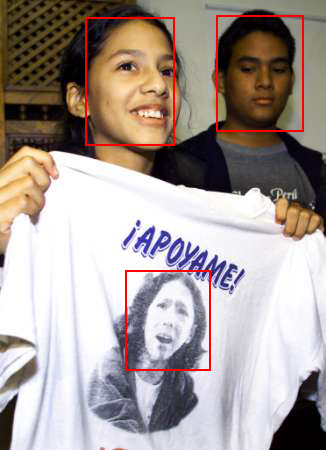

In [12]:
img_k = 996
draw_boxes(df_images.loc[img_k-1].path, vd1.predict_one_image(df_images.loc[img_k-1], merge=True), None, 'red')

In [13]:
test_images = glob.glob('test\*')
test_images = pd.DataFrame(test_images, columns=['path'])
test_images['w'] = test_images.path.apply(lambda x: Image.open(x).size[0])
test_images['h'] = test_images.path.apply(lambda x: Image.open(x).size[1])
test_images['k'] = [x for x in range(1, 501)]
test_images

,path,w,h,k
0,test\0001.jpg,337,410,1
1,test\0002.jpg,309,450,2
2,test\0003.jpg,346,450,3
3,test\0004.jpg,437,292,4
4,test\0005.jpg,648,432,5
...,...,...,...,...
495,test\0496.jpg,323,450,496
496,test\0497.jpg,322,450,497
497,test\0498.jpg,450,348,498
498,test\0499.jpg,273,410,499


In [65]:
test_images.loc[0]

path    test\0001.jpg
w                 337
h                 410
k                   1
Name: 0, dtype: object

In [14]:
preds = vd1.predict(test_images)

In [15]:
preds

,k,i,j,h,w
0,1,24,126,200,100
1,2,56,76,225,156
2,3,30,97,178,111
3,6,135,137,100,85
4,7,60,54,250,212
...,...,...,...,...,...
548,496,60,37,250,212
549,497,37,108,150,92
550,498,23,178,122,88
551,499,50,80,144,91


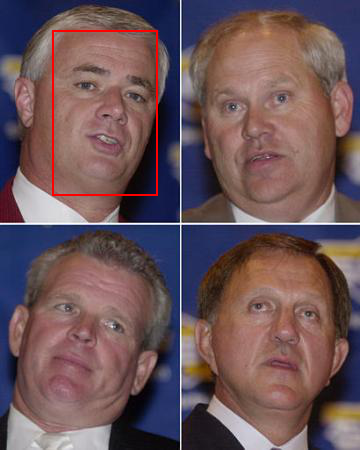

In [50]:
img_test_k = 422
draw_boxes(test_images.loc[img_test_k-1].path, preds[preds.k == img_test_k], None, 'red')

In [27]:
vd1 = visage_detector(model, stride=30, ws=[(100,85),(200,100),(250,212)] , pred_t=0.980422)
preds = vd1.predict(test_images)
preds = vd1.get_merged_box_score(test_images, preds)

553 (32, 32, 3)


In [28]:
preds = preds[preds.score > 0.980422]

In [30]:
preds['k'] = preds.apply(lambda x: f"{x.k:03d}", axis=1)
preds['score'] = preds.apply(lambda x: f"{x.score:0.2f}", axis=1)

ValueError: Unknown format code 'd' for object of type 'float'

In [35]:
preds['k'] = preds['k'].astype(int)
preds['score'] = preds.apply(lambda x: f"{x.score:0.2f}", axis=1)

In [36]:
preds

,k,i,j,h,w,score
0,1,24,126,200,100,1.00
1,2,56,76,225,156,1.00
2,3,30,97,178,111,1.00
3,6,135,137,100,85,1.00
4,7,60,54,250,212,1.00
...,...,...,...,...,...,...
548,496,60,37,250,212,1.00
549,497,37,108,150,92,1.00
550,498,23,178,122,88,1.00
551,499,50,80,144,91,1.00


In [37]:
preds.to_csv('sub.txt', index=False, columns=['k', 'i', 'j', 'h', 'w', 'score'], header=False, sep=' ')